# Add Titles and introductory info here

## Collect Data:

In [1]:
# Import dependencies:

import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
from config import api_key
import time   #used for time.sleep

In [2]:
# Generate a random list of 500 unique cities with a reasonably even distribution across the globe

# Set a range for lat and lng that includes the whole Earth
# latitude range is -90 to 90, longitude range is -180 to 180
lats = []
longs = []

lats = np.random.uniform(-90, 90, 25)
longs = np.random.uniform(-180, 180, 25)

#print(lats)
#print(longs)

In [3]:
# zip lists together to form coordinates
lat_long = zip(lats, longs)
lat_long

In [4]:
# Use citipy to find cities near coordinates

#Import citipy
from citipy import citipy

cities = []
countries = []

for lat_long in lat_long:
    city = citipy.nearest_city(lat_long[0], lat_long[1]).city_name
    country = citipy.nearest_city(lat_long[0], lat_long[1]).country_code
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)
        countries.append(country)

# Print the city count to confirm sufficient count
print(len(cities))
print(len(countries))

24
24


In [5]:
# Format data for improved legibility
cities = [city.title() for city in cities]
countries = [country.upper() for country in countries]

In [6]:
# Build dataframe to hold data
weather_df = pd.DataFrame({"Cities" : cities, "Countries" : countries})
weather_df.head()

,Cities,Countries
0,Fairbanks,US
1,Boyolangu,ID
2,Mahebourg,MU
3,Atuona,PF
4,Jamestown,SH


In [7]:
# Check for NaNs
weather_df.isnull().sum()

Cities       0
Countries    0
dtype: int64

In [8]:
# Add places to hold data for each city

weather_df["Latitude"] = ""
weather_df["Longitude"] = ""
weather_df["Temperature (F)"] = ""
weather_df["Humidity (%)"] = ""
weather_df["Cloudiness"] = ""
weather_df["Wind Speed (mph)"] = ""
weather_df.head()

,Cities,Countries,Latitude,Longitude,Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph)
0,Fairbanks,US,,,,,,
1,Boyolangu,ID,,,,,,
2,Mahebourg,MU,,,,,,
3,Atuona,PF,,,,,,
4,Jamestown,SH,,,,,,


In [9]:
# Use OpenWeather to get weather data for generated list of cities, test on one city

base_url = "http://api.openweathermap.org/data/2.5/weather?"
city_name = "Minneapolis"
country_code = "US"
query_url = f"{base_url}q={city_name},{country_code}&appid={api_key}&units=imperial"
#print(query_url) - test url worked
#minneapolis_weather = requests.get(query_url).json()
#minneapolis_weather

In [10]:
# Build a for loop to use the city names to call the OpenWeather API
# Test to ensure that the city has data, otherwise skip
# Generate a print log for each city as it is being processed

my_params = {"appid" : api_key, "units" : "imperial"}

for index, row in weather_df.iterrows():
    base_url = "http://api.openweathermap.org/data/2.5/weather?"
    city = row["Cities"]
    country = row["Countries"]
    
    my_params['q'] = f'{city},{country}'
    
    #make request
    cities_weather = requests.get(base_url, params=my_params).json()
    print(index, city)
    try:
        weather_df.loc[index, "Latitude"] = cities_weather["coord"]["lat"]
    except KeyError:
        weather_df.loc[index, "Latitude"] = np.nan
        print("skip")
        continue
       
    weather_df.loc[index, "Longitude"] = cities_weather["coord"]["lon"]
    weather_df.loc[index, "Temperature (F)"] = cities_weather["main"]["temp"]
    weather_df.loc[index, "Humidity (%)"] = cities_weather["main"]["humidity"]
    weather_df.loc[index, "Cloudiness"] = cities_weather["clouds"]["all"]
    weather_df.loc[index, "Wind Speed (mph)"] = cities_weather["wind"]["speed"]
        
    time.sleep(1)
        

0 Fairbanks
1 Boyolangu
2 Mahebourg
3 Atuona
4 Jamestown
5 Hermanus
6 Prince Rupert
7 Butaritari
8 Margherita
9 Iskateley
10 Monrovia
11 Le Port
12 Marsh Harbour
13 Mecca
14 Victoria
15 Rikitea
16 Aflu
skip
17 Port Alfred
18 Geraldton
19 Mataura
skip
20 Clyde River
21 Saint-Philippe
22 Avera
skip
23 Cururupu


In [11]:
weather_df

,Cities,Countries,Latitude,Longitude,Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph)
0,Fairbanks,US,64.8378,-147.716,-21.89,68,1,4.68
1,Boyolangu,ID,-8.1181,111.894,85.75,68,55,7.7
2,Mahebourg,MU,-20.4081,57.7,84.2,65,40,12.66
3,Atuona,PF,-9.8,-139.033,79.34,76,16,19.46
4,Jamestown,SH,-15.9387,-5.7168,67.86,88,95,14.67
5,Hermanus,ZA,-34.4187,19.2345,55,94,5,0.81
6,Prince Rupert,CA,54.3161,-130.32,30.61,54,1,10.36
7,Butaritari,KI,3.0707,172.79,81.32,80,32,17.25
8,Margherita,IN,27.2833,95.6833,69.8,52,4,6.91
9,Iskateley,RU,67.6803,53.1512,-14.71,88,100,17.69


In [12]:
#Drop rows with missing values
weather_df.dropna(inplace=True)
weather_df.reset_index(drop=True, inplace=True)
weather_df

,Cities,Countries,Latitude,Longitude,Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph)
0,Fairbanks,US,64.8378,-147.716,-21.89,68,1,4.68
1,Boyolangu,ID,-8.1181,111.894,85.75,68,55,7.7
2,Mahebourg,MU,-20.4081,57.7,84.2,65,40,12.66
3,Atuona,PF,-9.8,-139.033,79.34,76,16,19.46
4,Jamestown,SH,-15.9387,-5.7168,67.86,88,95,14.67
5,Hermanus,ZA,-34.4187,19.2345,55,94,5,0.81
6,Prince Rupert,CA,54.3161,-130.32,30.61,54,1,10.36
7,Butaritari,KI,3.0707,172.79,81.32,80,32,17.25
8,Margherita,IN,27.2833,95.6833,69.8,52,4,6.91
9,Iskateley,RU,67.6803,53.1512,-14.71,88,100,17.69


In [13]:
# Save a CSV file containing all weather data

weather_df.to_csv("cities_weather.csv", encoding='utf-8', index=False)

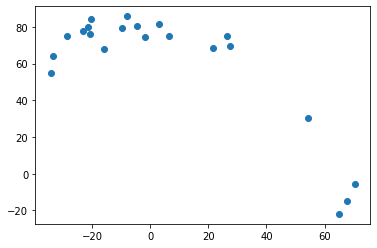

In [14]:
# Make a scatter plot to show relationship of temperature v latitude

x = weather_df["Latitude"]
y = weather_df["Temperature (F)"]

temp_plt = plt.scatter(x, y, marker="o")

plt.show()



# Save plot as a PNG file

## After each plot, add a sentence or two explaining what the code is analyzing.

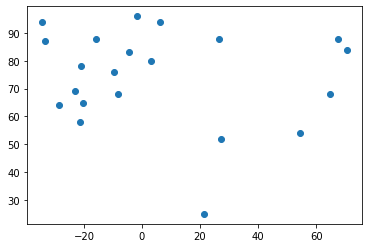

In [15]:
# Make a scatter plot to show the relationship of humidity v latitude

x = weather_df["Latitude"]
y = weather_df["Humidity (%)"]

temp_plt = plt.scatter(x, y, marker="o")

plt.show()

# After each plot, add a sentence or two explaining what the code is analyzing.
# Save plot as a PNG file

## After each plot, add a sentence or two explaining what the code is analyzing.

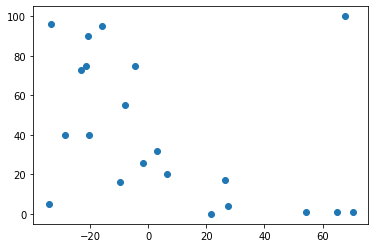

In [16]:
# Make a scatter plot to show the relationship of cloudiness v latitude

x = weather_df["Latitude"]
y = weather_df["Cloudiness"]

temp_plt = plt.scatter(x, y, marker="o")

plt.show()

# After each plot, add a sentence or two explaining what the code is analyzing.
# Save plot as a PNG file

## After each plot, add a sentence or two explaining what the code is analyzing.

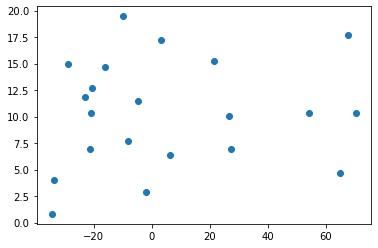

In [17]:
# Make a scatter plot to show the relationship of wind speed v latitude

x = weather_df["Latitude"]
y = weather_df["Wind Speed (mph)"]

temp_plt = plt.scatter(x, y, marker="o")

plt.show()

# After each plot, add a sentence or two explaining what the code is analyzing.
# Save plot as a PNG file

## After each plot, add a sentence or two explaining what the code is analyzing.

In [ ]:
# The second requirement is to run linear regression on each relationship. This time, separate the plots 
# into Northern Hemisphere (greater than or equal to 0 degrees latitude) and Southern Hemisphere (less than 0 
# degrees latitude):

In [31]:
# Study data files


In [32]:
# Create bins and bin data

bins = [-90, 0, 90]
labels = ["south", "north"]
weather_df["Hemisphere"] = pd.cut(weather_df["Latitude"], bins=bins, labels=labels)
weather_df

,Cities,Countries,Latitude,Longitude,Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph),Hemisphere
0,Fairbanks,US,64.8378,-147.716,-21.89,68,1,4.68,north
1,Boyolangu,ID,-8.1181,111.894,85.75,68,55,7.7,south
2,Mahebourg,MU,-20.4081,57.7,84.2,65,40,12.66,south
3,Atuona,PF,-9.8,-139.033,79.34,76,16,19.46,south
4,Jamestown,SH,-15.9387,-5.7168,67.86,88,95,14.67,south
5,Hermanus,ZA,-34.4187,19.2345,55,94,5,0.81,south
6,Prince Rupert,CA,54.3161,-130.32,30.61,54,1,10.36,north
7,Butaritari,KI,3.0707,172.79,81.32,80,32,17.25,north
8,Margherita,IN,27.2833,95.6833,69.8,52,4,6.91,north
9,Iskateley,RU,67.6803,53.1512,-14.71,88,100,17.69,north


In [29]:
# Split data into two frames, one for each hemisphere

weather_north_df = weather_df.loc[weather_df["Hemisphere"] == "north"]
weather_north_df.reset_index(inplace=True, drop=True)
type(weather_north_df["Latitude"][0])

float

In [30]:
# define values for northern hemisphere
x_values = weather_north_df["Latitude"]
y_values = weather_north_df["Temperature (F)"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y=" + str(round(slope,2)) + "x " + str(round(intercept,2))
plt.scatter(x_values, y_values)
plt.plot(x_values, regress_values, "r-")
plt.annotate(line_eq, (21,37), fontsize=15, color="red")
#plt.xlabel("Mouse Weight (g)")
#plt.ylabel("Tumor Volume (mm3)")
plt.show()

AttributeError: 'float' object has no attribute 'shape'

In [ ]:
break

In [ ]:
# Same for southern hemisphere

weather_south_df = weather_df.loc[weather_df["Hemisphere"] == "south"]
weather_south_df.reset_index(inplace=True, drop=True)
weather_south_df

In [ ]:
# Northern Hemisphere - Temperature (F) vs. Latitude
# Southern Hemisphere - Temperature (F) vs. Latitude

# define values for northern hemisphere
xn_values = weather_north_df["Latitude"].to_list()
yn_values = weather_north_df["Temperature (F)"].to_list()

#calculate regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(xn_values, yn_values)
print(slope)

In [ ]:
regress_n = xn_values * slope + intercept
line_eq = "y=" + str(round(slope,2)) + "x " + str(round(intercept,2))

In [ ]:
#define values for southern hemisphere
xs = weather_south_df["Latitude"].to_list()
ys = weather_south_df["Temperature (F)"].to_list()

#calculate regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(xs, ys)
regress_s = xs * slope + intercept
line_eq = "y=" + str(round(slope,2)) + "x " + str(round(intercept,2))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
fig.suptitle('')
ax1.scatter(xs, ys)
ax1.set_xlim(left=-90, right=0)
ax1.plot(xn, regress_n, "r-")
ax1.annotate(line_eq, (21,37), fontsize=15, color="red")
ax2.scatter(xn, yn)
ax2.set_xlim(left=0, right=90)
ax2.plot(x_values, regress_values, "r-")
ax2.annotate(line_eq, (21,37), fontsize=15, color="red")
plt.show()

In [ ]:
# Northern Hemisphere - Humidity (%) vs. Latitude
# Southern Hemisphere - Humidity (%) vs. Latitude

xn = weather_north_df["Latitude"]
yn = weather_north_df["Humidity (%)"]

xs = weather_south_df["Latitude"]
ys = weather_south_df["Humidity (%)"]

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
fig.suptitle('')
ax1.scatter(xs, ys)
ax1.set_xlim(left=-90, right=0)
ax2.scatter(xn, yn)
ax2.set_xlim(left=0, right=90)
plt.show()

In [ ]:
# Northern Hemisphere - Cloudiness (%) vs. Latitude
# Southern Hemisphere - Cloudiness (%) vs. Latitude

xn = weather_north_df["Latitude"]
yn = weather_north_df["Cloudiness"]

xs = weather_south_df["Latitude"]
ys = weather_south_df["Cloudiness"]

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
fig.suptitle('')
ax1.scatter(xs, ys)
ax1.set_xlim(left=-90, right=0)
ax2.scatter(xn, yn)
ax2.set_xlim(left=0, right=90)
plt.show()

In [ ]:
# Northern Hemisphere - Wind Speed (mph) vs. Latitude
# Southern Hemisphere - Wind Speed (mph) vs. Latitude

xn = weather_north_df["Latitude"]
yn = weather_north_df["Wind Speed (mph)"]

xs = weather_south_df["Latitude"]
ys = weather_south_df["Wind Speed (mph)"]

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
fig.suptitle('')
ax1.scatter(xs, ys)
ax1.set_xlim(left=-90, right=0)
ax2.scatter(xn, yn)
ax2.set_xlim(left=0, right=90)
plt.show()

In [ ]:
# After each pair of plots, take the time to explain what the linear regression is modeling. 
# For example, describe any relationships you notice and any other analysis you may have.